In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torchaudio
from tqdm.auto import tqdm
import noisereduce as nr
import opensmile

from plotly_resampler import FigureResampler
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from ipywidgets import Output, GridspecLayout

sys.path.append("..")
from sgs_utils.path_conf import (
    loc_data_dir,
    speech_data_session_dir,
    interim_speech_data_dir,
)
from sgs_utils.data_filtering import get_valid_audio_mask

from IPython.display import Audio, display

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
sns.set_context("talk")
sns.set_style("whitegrid")  

# https://pytorch.org/audio/stable/backend.html#module-torchaudio.backend
torchaudio.get_audio_backend()

from speechbrain.pretrained import VAD
import torch


In [3]:
df_session = pd.read_parquet(loc_data_dir.joinpath("df_session_tot_cleaned.parquet"))

# load the model
VAD_model = VAD.from_hparams(
    source="speechbrain/vad-crdnn-libriparty", savedir=".vad_model"
)

smile_lld = opensmile.Smile(
    # feature_set=opensmile.FeatureSet.GeMAPSv01b,
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)
# feat_cols = ["F0semitoneFrom27.5Hz_sma3nz", "jitterLocal_sma3nz"]
feat_cols = ["F0final_sma", "voicingFinalUnclipped_sma"]


# Analyze the audio quality 

This notebook applyes the `Analyze` step of the speech data processing pipeline.

![](https://cdn.discordapp.com/attachments/372491075153166338/1049274916106665985/2022-12-01_15-08-45.jpeg)

## On a user level

In [4]:
from sgs_utils.speech_analysis import analyze_audio_quality

age-sex: 30 - female		education: ho		device: pc-mic
#Radboud: 15   -   #Pisces: 15   -   #Marloes: 7  -  SR=48000Hz


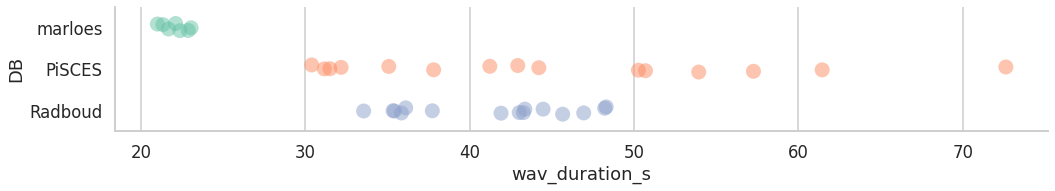

============================== marloes ==============================
Playing from 5 to 10 seconds  |orig norm| 16khz norm |


GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

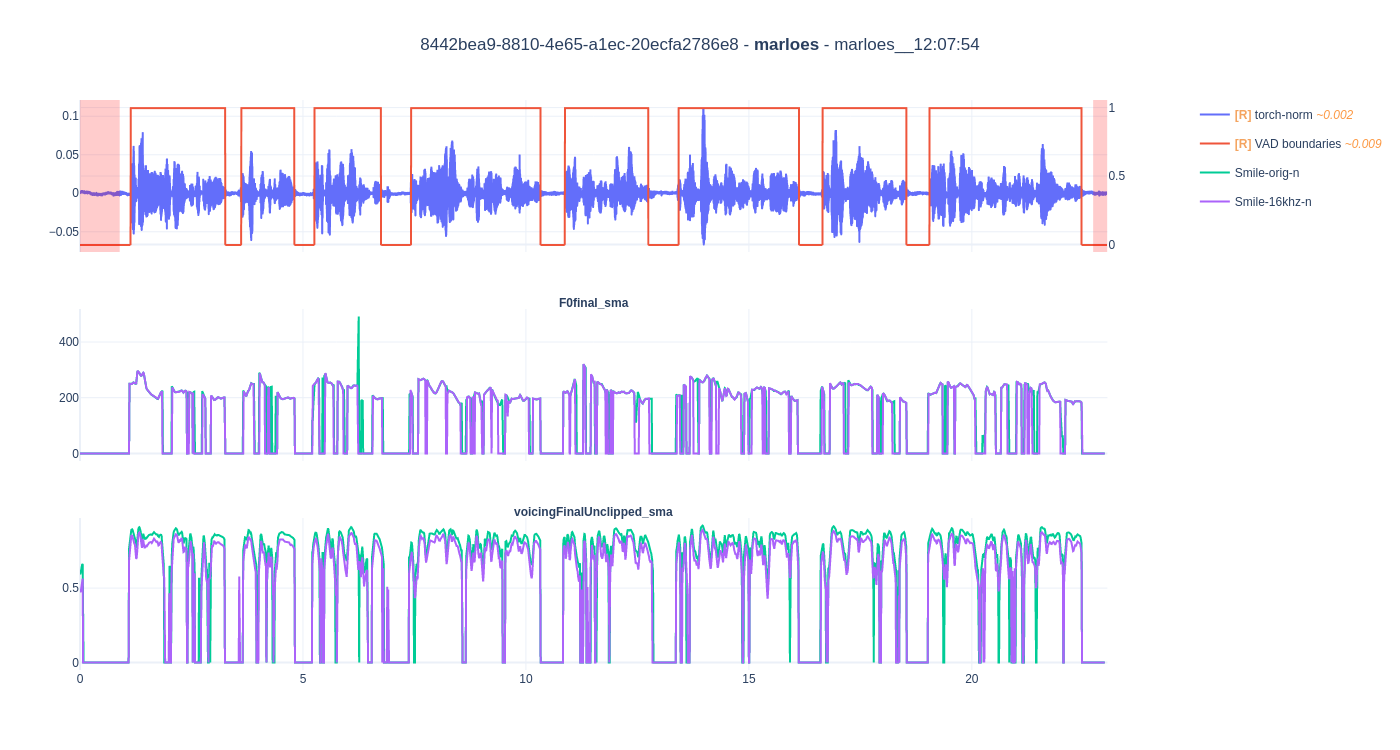

============================== Radboud ==============================
Playing from 5 to 10 seconds  |orig norm| 16khz norm |


GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

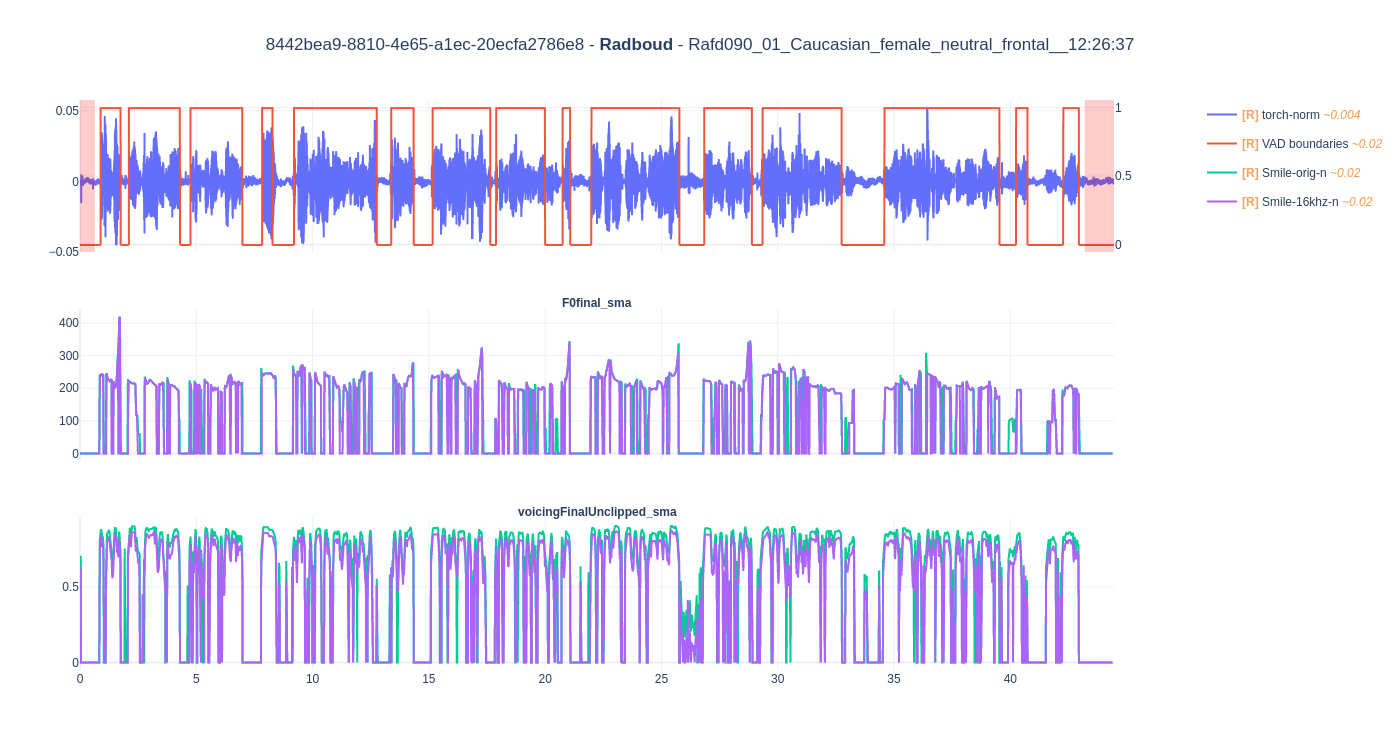

,norm_16Khz__marloes_1_1,norm_16Khz__Radboud_10_24
F0final_sma,0.846000,0.865000
voicingFinalUnclipped_sma,0.955000,0.958000
jitterLocal_sma,0.416000,0.542000
jitterDDP_sma,0.204000,0.497000
shimmerLocal_sma,0.711000,0.700000
logHNR_sma,0.894000,0.891000
audspec_lengthL1norm_sma,1.000000,1.000000
audspecRasta_lengthL1norm_sma,1.000000,1.000000
pcm_RMSenergy_sma,0.989000,0.986000
pcm_zcr_sma,0.961000,0.963000


In [5]:
row =  43
case = 1

if case == 1:  # Compare
    smile_lld = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
    )
    feat_cols = [
        "F0final_sma",
        "voicingFinalUnclipped_sma",
    ]  # emobase
    numb_dict = { 'n_marloes': 1, 'n_radboud': 1, 'n_pisces': 0 }
else:  # if case == 1:  # Gemaps
    smile_lld = opensmile.Smile(
        feature_set=opensmile.FeatureSet.GeMAPSv01b,
        feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
    )
    feat_cols = ["F0semitoneFrom27.5Hz_sma3nz", "jitterLocal_sma3nz"]  # gemaps
    numb_dict = { 'n_marloes': 0, 'n_radboud': 0, 'n_pisces': 2 }

analyze_audio_quality(
    df_session=df_session,
    ID=np.unique(df_session.ID)[row - 2],
    **numb_dict,
    plot=True,
    plot_type='png',
    audio=True,
    norm_audio=True,
    vad=True,
    show_wav_features=False,
    noise_reduction=False,
    audio_begin_s=5,
    audio_end_s=10,
    smile_lld=smile_lld,
    feat_cols=feat_cols,
)


## On an utterance level

In [6]:
from sgs_utils.speech_analysis import analyze_utterance
from sgs_utils.data_filtering import _get_silent_recording_mask
df_silent_sessions = df_session[_get_silent_recording_mask(df_session)]

age-sex: 29 - female		education: unif		device: pc-mic


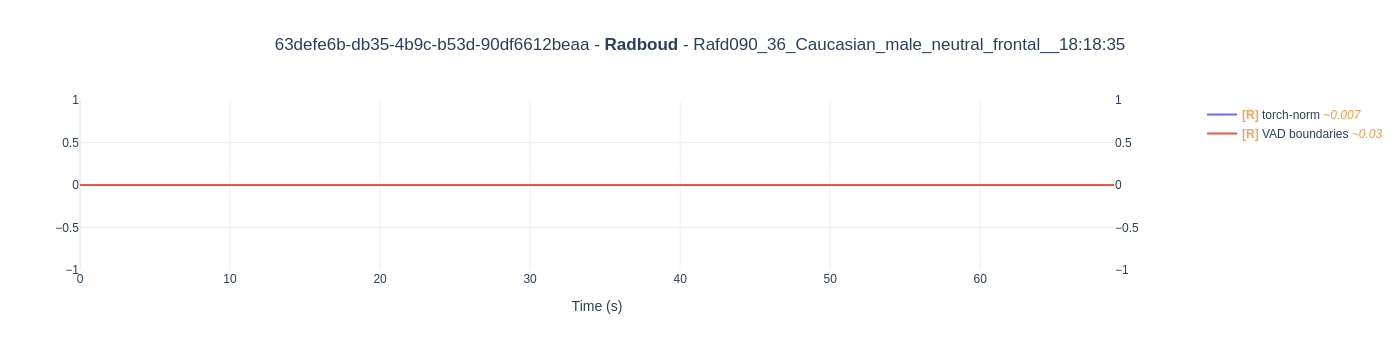

In [15]:
# Visualize a silent session
analyze_utterance(
    utterance=df_silent_sessions.iloc[5],
    # utterance=df_session[
    #     # (df_session.ID == "099ceb4d-28f3-4b1f-8f8e-16b439a882f1")
    #     (df_session.wav_duration_s <= 40)
    #     # & (df_session.time_str == "17:06:37")
    # ]
    # .sample(1)
    # .iloc[0],
    smile_lld=None,
    feat_cols=[],
    # utterance=df_session.sample(1).iloc[0],
    plot=True,
    audio=False,
    norm_audio=False,
    vad=True,
    noise_reduction=False,
    audio_begin_s=40,
    audio_end_s=50,
    show_corr=False,
    plot_type="png",
)


note: the VAD model does not detect any speech segments 🎉

age-sex: 25 - female		education: ho		device: headset
Playing from 0 to 40 seconds


GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

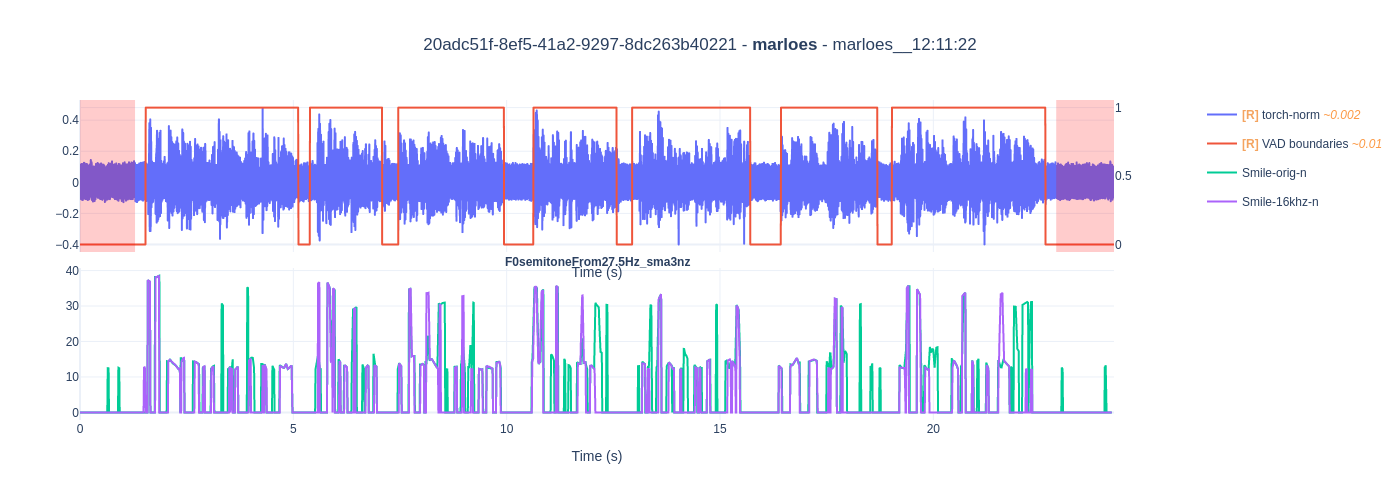

In [16]:
analyze_utterance(
    # A session with a high noise level
    utterance=df_session[
        (df_session.ID == "20adc51f-8ef5-41a2-9297-8dc263b40221")
        & (df_session.time_str == "12:11:22")
    ]
    .sample(1)
    .iloc[0],
    feat_cols= ["F0semitoneFrom27.5Hz_sma3nz"],
    plot=True,
    audio=True,
    norm_audio=False,
    vad=True,
    noise_reduction=False,
    audio_begin_s=0,
    audio_end_s=40,
    show_corr=False,
    plot_type="png",
)


age-sex: 20 - male		education: so		device: pc-mic


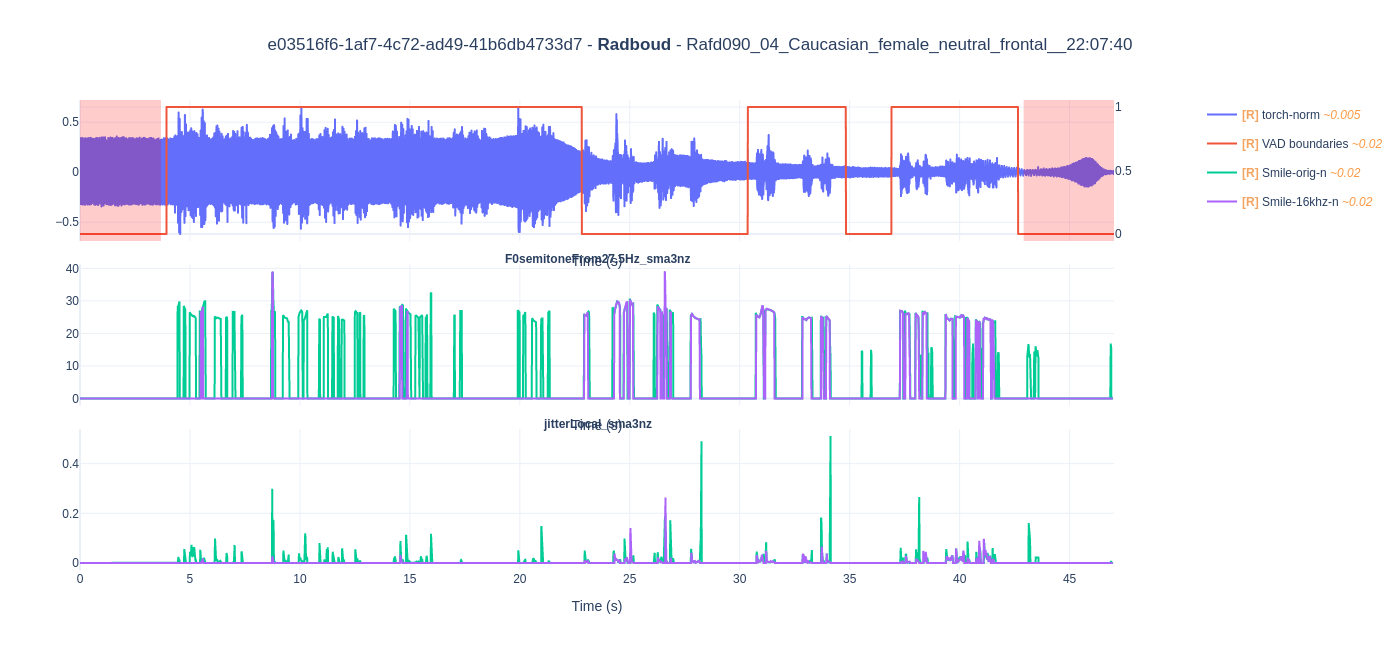

In [17]:
analyze_utterance(
    # Low quality session -> a lot of noise 
    #   => opensmile cannot qualitatively extract features
    utterance=df_session[
        (df_session.ID == "e03516f6-1af7-4c72-ad49-41b6db4733d7")
        & (df_session.time_str == "22:07:40")
    ]
    .sample(1)
    .iloc[0],
    plot=True,
    audio=False,
    norm_audio=False,
    vad=True,
    noise_reduction=False,
    audio_begin_s=0,
    audio_end_s=40,
    show_corr=False,
    plot_type="png",
)
